In [ ]:
# for this RCNN model, this tutorial was followed: https://towardsdatascience.com/step-by-step-r-cnn-implementation-from-scratch-in-python-e97101ccde55

In [2]:
import os,cv2,keras
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

In [3]:
ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()

In [4]:
def get_iou(bb1, bb2):
    assert bb1['x1'] < bb1['x2']
    assert bb1['y1'] < bb1['y2']
    assert bb2['x1'] < bb2['x2']
    assert bb2['y1'] < bb2['y2']

    x_left = max(bb1['x1'], bb2['x1'])
    y_top = max(bb1['y1'], bb2['y1'])
    x_right = min(bb1['x2'], bb2['x2'])
    y_bottom = min(bb1['y2'], bb2['y2'])

    if x_right < x_left or y_bottom < y_top:
        return 0.0

    intersection_area = (x_right - x_left) * (y_bottom - y_top)

    bb1_area = (bb1['x2'] - bb1['x1']) * (bb1['y2'] - bb1['y1'])
    bb2_area = (bb2['x2'] - bb2['x1']) * (bb2['y2'] - bb2['y1'])

    iou = intersection_area / float(bb1_area + bb2_area - intersection_area)
    assert iou >= 0.0
    assert iou <= 1.0
    return iou

In [5]:
train_images=[]
train_labels=[]
#train_images = r'/content/Airplane Images'
#train_labels = r'/content/Airplane Annotations'
path = r'/content/Airplane Images'
annot = r'/content/Airplane Annotations'
for e,i in enumerate(os.listdir(annot)):
    try:
        if i.startswith("airplane"):
            filename = i.split(".")[0]+".jpg"
            print(e,filename)
            image = cv2.imread(os.path.join(path,filename))
            df = pd.read_csv(os.path.join(annot,i))
            gtvalues=[]
            for row in df.iterrows():
                x1 = int(row[1][0].split(" ")[0])
                y1 = int(row[1][0].split(" ")[1])
                x2 = int(row[1][0].split(" ")[2])
                y2 = int(row[1][0].split(" ")[3])
                gtvalues.append({"x1":x1,"x2":x2,"y1":y1,"y2":y2})
            ss.setBaseImage(image)
            ss.switchToSelectiveSearchFast()
            ssresults = ss.process()
            imout = image.copy()
            counter = 0
            falsecounter = 0
            flag = 0
            fflag = 0
            bflag = 0
            for e,result in enumerate(ssresults):
                if e < 2000 and flag == 0:
                    for gtval in gtvalues:
                        x,y,w,h = result
                        iou = get_iou(gtval,{"x1":x,"x2":x+w,"y1":y,"y2":y+h})
                        if counter < 30:
                            if iou > 0.70:
                                timage = imout[y:y+h,x:x+w]
                                resized = cv2.resize(timage, (224,224), interpolation = cv2.INTER_AREA)
                                train_images.append(resized)
                                train_labels.append(1)
                                counter += 1
                        else :
                            fflag =1
                        if falsecounter <30:
                            if iou < 0.3:
                                timage = imout[y:y+h,x:x+w]
                                resized = cv2.resize(timage, (224,224), interpolation = cv2.INTER_AREA)
                                train_images.append(resized)
                                train_labels.append(0)
                                falsecounter += 1
                        else :
                            bflag = 1
                    if fflag == 1 and bflag == 1:
                        print("inside")
                        flag = 1
    except Exception as e:
        print(e)
        print("error in "+filename)
        continue

0 airplane_002.jpg
1 airplane_001.jpg
inside
2 airplane_007.jpg
inside
3 airplane_006.jpg
4 airplane_008.jpg
5 airplane_003.jpg
6 airplane_009.jpg
7 airplane_005.jpg
inside
8 airplane_010.jpg
9 airplane_004.jpg
inside


In [6]:
X_new = np.array(train_images)
y_new = np.array(train_labels)

In [7]:
from keras.layers import Dense
from keras import Model
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.applications.vgg16 import VGG16
vggmodel = VGG16(weights='imagenet', include_top=True)

In [8]:
for layers in (vggmodel.layers)[:15]:
    print(layers)
    layers.trainable = False
X= vggmodel.layers[-2].output
predictions = Dense(2, activation="softmax")(X)
#model_final = Model(input = vggmodel.input, output = predictions)
model_final = Model(vggmodel.input,predictions)
opt = Adam(lr=0.0001)
model_final.compile(loss = keras.losses.categorical_crossentropy, optimizer = opt, metrics=["accuracy"])
model_final.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [9]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
class MyLabelBinarizer(LabelBinarizer):
    def transform(self, y):
        Y = super().transform(y)
        if self.y_type_ == 'binary':
            return np.hstack((Y, 1-Y))
        else:
            return Y
    def inverse_transform(self, Y, threshold=None):
        if self.y_type_ == 'binary':
            return super().inverse_transform(Y[:, 0], threshold)
        else:
            return super().inverse_transform(Y, threshold)
lenc = MyLabelBinarizer()
Y =  lenc.fit_transform(y_new)
X_train, X_test , y_train, y_test = train_test_split(X_new,Y,test_size=0.10)

In [10]:
trdata = ImageDataGenerator(horizontal_flip=True, vertical_flip=True, rotation_range=90)
traindata = trdata.flow(x=X_train, y=y_train)
tsdata = ImageDataGenerator(horizontal_flip=True, vertical_flip=True, rotation_range=90)
testdata = tsdata.flow(x=X_test, y=y_test)

In [11]:
from keras.callbacks import ModelCheckpoint, EarlyStopping
checkpoint = ModelCheckpoint("ieeercnn_vgg16_1.h5", monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
early = EarlyStopping(monitor='val_loss', min_delta=0, patience=100, verbose=1, mode='auto')
hist = model_final.fit_generator(generator= traindata, steps_per_epoch= 1, epochs= 10, validation_data= testdata, validation_steps=2, callbacks=[checkpoint,early])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  after removing the cwd from sys.path.


Epoch 1/10
1/1 [==============================] - ETA: 0s - loss: 1.3668 - accuracy: 0.2188
Epoch 1: val_loss improved from inf to 1.26434, saving model to ieeercnn_vgg16_1.h5
1/1 [==============================] - 57s 57s/step - loss: 1.3668 - accuracy: 0.2188 - val_loss: 1.2643 - val_accuracy: 0.8298
Epoch 2/10
1/1 [==============================] - ETA: 0s - loss: 1.7161 - accuracy: 0.7812
Epoch 2: val_loss improved from 1.26434 to 1.18807, saving model to ieeercnn_vgg16_1.h5
1/1 [==============================] - 53s 53s/step - loss: 1.7161 - accuracy: 0.7812 - val_loss: 1.1881 - val_accuracy: 0.8511
Epoch 3/10
1/1 [==============================] - ETA: 0s - loss: 6.7199 - accuracy: 0.5000
Epoch 3: val_loss improved from 1.18807 to 0.69916, saving model to ieeercnn_vgg16_1.h5
1/1 [==============================] - 35s 35s/step - loss: 6.7199 - accuracy: 0.5000 - val_loss: 0.6992 - val_accuracy: 0.8723
Epoch 4/10
1/1 [==============================] - ETA: 0s - loss: 0.4980 - accur

In [12]:
z=0
for e,i in enumerate(os.listdir(path)):
    if i.startswith("4"):
        z += 1
        img = cv2.imread(os.path.join(path,i))
        ss.setBaseImage(img)
        ss.switchToSelectiveSearchFast()
        ssresults = ss.process()
        imout = img.copy()
        for e,result in enumerate(ssresults):
            if e < 2000:
                x,y,w,h = result
                timage = imout[y:y+h,x:x+w]
                resized = cv2.resize(timage, (224,224), interpolation = cv2.INTER_AREA)
                img = np.expand_dims(resized, axis=0)
                out= model_final.predict(img)
                if out[0][0] > 0.70:
                    cv2.rectangle(imout, (x, y), (x+w, y+h), (0, 255, 0), 1, cv2.LINE_AA)
        plt.figure()
        plt.imshow(imout)
        break

<function matplotlib.pyplot.show(*args, **kw)>

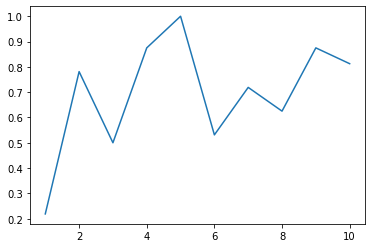

In [13]:
#graphs the accuracies of the training done above`
epochs = np.array([1,2,3,4,5,6,7,8,9,10])
accuracies = np.array([0.2188,0.7812,0.5,0.8750, 1, 0.5312, 0.7188, 0.625, 0.875, 0.8125])
#above is the accuracies for my most recent test

plt.plot(epochs, accuracies)
plt.show

For my implementation, I decided to take a deper look into RCNN. To put it simply, RCNN is an extension of the standard CNN. RCNN has been improved on from the base CNN model in order to handle tasks in object detection, while the base CNN is more suited for image classification. For this particular implementation, I used a dataset to detect whether an airplane was in the image or not. 

The main metric I am using to measure success of the implementation is accuracy. I believe that an accuracy of at least .95 is required for something that would be implemented in actuality. The main reason the accuracy for my particular implementation was so low overall was due to me drastically scaling back the training for the sake of time. If I had actually used the full dataset and much more epochs, I am sure the accuracy would have met the benchmark of 0.95 at least. 

Like I mentioned above, in terms of improvements, the main thing I would do is a much more thorough training of the data. Another idea that comes to mind would be using images as varied as possible in order to help with any potential edge cases encountered in the process. I believe these two changes would greatly benefit the effectiveness of this model. 
